In [0]:
#!pip install tqdm -U

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
from tensorflow.python.client import device_lib
str(device_lib.list_local_devices()[-1]).split('\n')[-2]

'physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"'

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re 

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Домашняя работа 
### Урок 5. Рекуррентные нейронные сети

Попробуйте изменить параметры нейронной сети генерирующий текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший получившейся у вас текст и опишите, что вы предприняли, чтобы его получить. Можно использовать текст другого прозведения.

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Activation,Dropout
from keras.layers import LSTM,GRU, SimpleRNN, BatchNormalization


# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.2.0-rc3


Using TensorFlow backend.


In [0]:
SEED = 1 
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
np.random.seed(SEED)
tf.compat.v1.set_random_seed(SEED)

### whole word predictions

In [0]:
file_ = 'gdrive/My Drive/alice_in_wonderland.txt' 
with open(file_, 'rb') as f:
    alice = []
    for line in f:
        line = line.strip().lower().decode("ascii", "ignore")
        if line:
            alice.append(line)
# removing credits from begining and from the end
alice = alice[17:-297]

In [0]:
start_phrases = ['the lobster quadrille the mock ',
                 'kept fanning herself all the time',
                 'alice led the way and the whole',

                 'every morning alice eats ears',
                 'caterpillar smoking flower tea today',
                 'duchess so pretty when she',

                 'christian eastern goat sewing boxers',
                 'national anthem is greatest song',
                 'lord windsor shooting sqirrel immediately',

                 ]


In [0]:
def dict_words(text):
    text = " ".join(text)
    text_by_words = re.findall(r'\w+', text)
    words = set(text_by_words)
    return text_by_words, words


In [0]:
def model_by_world(text,start_set, n_iter = 10, s_len = 10):
    text_by_words, words = dict_words(text)
    dict_len = len(words)

    print(f'Created text_set {len(words)} words')
    
    word2index = {c: i for i, c in enumerate(words)}
    index2word = {i: c for i, c in enumerate(words)}

    input_words, label_words = [], []
    
    for i in range(0, len(text_by_words) - s_len, 1):
        input_words.append(text_by_words[i: i + s_len])
        label_words.append(text_by_words[i + s_len])

    X = np.zeros((len(input_words), s_len, dict_len), dtype=np.bool)
    y = np.zeros((len(input_words), dict_len), dtype=np.bool)
    
    for i, input_ in enumerate(input_words):
        for j, ch in enumerate(input_):
            X[i, j, word2index[ch]] = 1
        y[i, word2index[label_words[i]]] = 1
    
    model = model_build(s_len, dict_len)

    hist_loss = []

    for _ in tqdm(range (n_iter)):
        history = model.fit(X, y, batch_size=128, epochs= 1, verbose = 0)
        hist_loss.append(history.history['loss'])

    plt.plot(hist_loss);

    for start_ in start_set:
        start_ = start_.strip() .split(' ')[:s_len]
        test_word = start_.copy()
        predict_world = start_.copy()
        print(f'Predicting:')
        print(' '.join(test_word))

        for i in range(30):

            X_test = np.zeros((1, s_len, dict_len))
            for j, ch in enumerate(test_word):
                X_test[0, j, word2index[ch]] = 1

            pred = model.predict(X_test, verbose=0)[0]
            y_pred = index2word[np.argmax(pred)]
            predict_world += [y_pred]
            test_word = test_word[1:] + [y_pred]
        
        for i in range(3):
            print(' '.join(predict_world[:10]))
            predict_world = predict_world[10:]
        print(' '.join(predict_world))

        print()



Created text_set 2612 words


100%|██████████| 100/100 [04:40<00:00,  2.81s/it]


Predicting:
the lobster quadrille the mock
the lobster quadrille the mock turtle sighed deeply and began
in a voice sometimes choked with sobs to sing this
beautiful soup ive forgotten that ive got to into it
alice was only too glad

Predicting:
kept fanning herself all the
kept fanning herself all the time she went on talking
dear dear how queer everything is to day and yesterday
things i went sh just i never about it said
alice i must be shutting

Predicting:
alice led the way and
alice led the way and the whole party swam to
the shore chapter iii a caucus race and a long
tale they were indeed a queer looking party that assembled
on the bank the birds

Predicting:
every morning alice eats ears
every morning alice eats ears have alice had been before
she had sat down but im glad ive some herself
in i do alice hastily replied at least at least
i mean what i say

Predicting:
caterpillar smoking flower tea today
caterpillar smoking flower tea today i dont i know as
it would feel very que

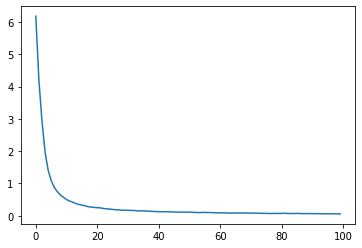

In [11]:
def model_build(SEQLEN, dict_len):
    model = Sequential()
    model.add(LSTM(512,
        return_sequences=False,
        input_shape=(SEQLEN, dict_len),
        unroll=True))

    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    
    model.add(Dense(dict_len))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam")
    return model

model_by_world(alice, start_phrases[:6], n_iter = 100, s_len = 5)

swallowed one of the cakes and was delighted to find
that her neck would bend about easily in any direction
like a serpent she had just succeeded in curving it
down into a graceful zigzag

In [0]:
file_ = 'gdrive/My Drive/Guest_From_Future.txt' 
with open(file_, encoding='CP1251') as f:
    guest = []
    for line in f:
        line = line.strip().lower().replace('\xa0', ' ')
        if line:
            guest.append(line)
guest= guest [10:]

In [0]:
start_phrases_guest = ['кто то шел по коридору остановился за дверью',
                       'с какой скоростью у вас автобусы ездят',
                       'нельзя я и так нарушила тайну я преступница',
                       
                       'сначала алиса была ребенок как ребенок',
                       'пять минут вокруг нас собрались все',
                       'ну это детям надо знать обязательно',
                       
                       'два шарика перекатиполя пролетели метрах',
                       'томас вскинул арбалет и не прицеливаясь',
                       'служит вахтером бывший пират сильвер джонович']

Created text_set 12771 words


100%|██████████| 30/30 [12:26<00:00, 24.87s/it]


Predicting:
кто то шел по коридору
кто то шел по коридору остановился ты так но не
вмешиваться и иди к доске кто от тебя ты а
если ты уж я нельзя я мы маленькие ты нового
в ты не знаешь я

Predicting:
с какой скоростью у вас
с какой скоростью у вас автобусы ездят а ни с
какой они ты не стоят ах ты а если у
тебя есть карта я тебе и сказала юлька если ты
я говорю ты тебе я

Predicting:
нельзя я и так нарушила
нельзя я и так нарушила тайну я преступница а если
ты начнешь спрашивать окажется что я притом и болтунья нет
я сама спрошу я бы и тебе ничего не рассказала
если бы пираты меня не

Predicting:
сначала алиса была ребенок как
сначала алиса была ребенок как ты а я где это
был такой я и если ты не понимаю они он
меня пригласил я думала он меня и не замечает он
такой ученый девочки а что

Predicting:
пять минут вокруг нас собрались
пять минут вокруг нас собрались у если ты у нас
да у нас где у вас и у тебя есть
карта никакого он и иди своей дорогой не пойду я
селекцию провожу а ты себя



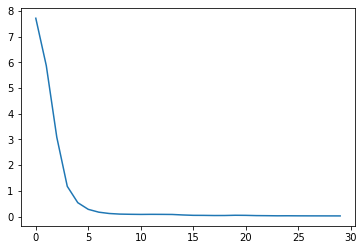

In [14]:
def model_build(SEQLEN, dict_len):
    model = Sequential()
    model.add(LSTM(512,
        return_sequences=False,
        input_shape=(SEQLEN, dict_len),
        unroll=True))

    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    
    model.add(Dense(dict_len))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam")
    return model

model_by_world(guest, start_phrases_guest[:6],n_iter = 30, s_len = 5)

### one letter predictions

In [0]:
def text_prep(text):
    text = " ".join(text)
    text = re.findall(r'\w+', text)
    text = " ".join(text).replace('_','')
    letters = set(text)
    return text, letters

In [0]:
def model_by_letter(text, start_set, n_iter = 10, s_len = 10):
    text, letters = text_prep(text)
    dict_len = len(letters)

    print(f'Created dictionary {len(letters)} letters')
    
    char2index = {c: i for i, c in enumerate(letters)}
    index2char = {i: c for i, c in enumerate(letters)}

    input_letters, label_letters = [], []
    
    for i in range(0, len(text) - s_len, 1):
        input_letters.append(text[i: i + s_len])
        label_letters.append(text[i + s_len])

    X = np.zeros((len(input_letters), s_len, dict_len), dtype=np.bool)
    y = np.zeros((len(input_letters), dict_len), dtype=np.bool)
    
    for i, input_ in enumerate(input_letters):
        for j, ch in enumerate(input_):
            X[i, j, char2index[ch]] = 1
        y[i, char2index[label_letters[i]]] = 1
    
    model = model_build(s_len, dict_len)

    hist_loss = []

    for _ in tqdm(range (n_iter)):
        history = model.fit(X, y, batch_size=512, epochs= 1, verbose = 0)
        hist_loss.append(history.history['loss'])

    plt.plot(hist_loss);

    print()
    for start_ in start_set:
        test_letter = start_[:s_len]
        predict_text = start_[:s_len]
        print(f'Predicting:{test_letter}')

        for i in range(150):

            X_test = np.zeros((1, s_len, dict_len))
            for j, ch in enumerate(test_letter):
                X_test[0, j, char2index[ch]] = 1

            pred = model.predict(X_test, verbose=0)[0]
            y_pred = index2char[np.argmax(pred)]
            predict_text += y_pred
            test_letter = test_letter[1:] + y_pred
        
        predict_world = predict_text.split(' ')
        for i in range(3):
            print(' '.join(predict_world[:10]))
            predict_world = predict_world[10:]
        print(' '.join(predict_world))

        print()



# 1 R-layer 

Created dictionary 27 letters


100%|██████████| 100/100 [12:03<00:00,  7.24s/it]



Predicting:the lobster quadrille the
the lobster quadrille the gryphon went on or would you
like the mock turtle so she telpen ith and she
while please your majesty said the knave the king were
why thats nimber y

Predicting:kept fanning herself all 
kept fanning herself all the time she went on talking
dear dear how queer everything is to day and yesterday
things went on just as usual i wonder if ive
been changed in the n

Predicting:alice led the way and the
alice led the way and the whole party swam to
the shore chapter iii a caucus race and a long
tale they were indeed a queer looking party that assembled
on the bank the birds w

Predicting:every morning alice eats 
every morning alice eats chrewert and looked at her face
in the poor aniin the first notter number ofe ead
but there was no one the kings argument was that
anything that had a

Predicting:caterpillar smoking flowe
caterpillar smoking flower down here thong the best bate in
a waitther finished this sitting on a brown ch

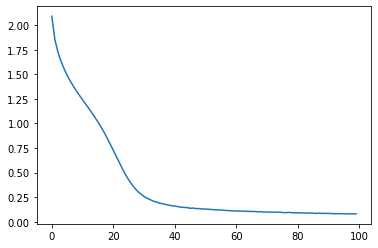

In [17]:
def model_build(SEQLEN, dict_len):
    model = Sequential()
    model.add(GRU(512,
        return_sequences=False,
        input_shape=(SEQLEN, dict_len),
        unroll=True))

    model.add(BatchNormalization())
    model.add(Dropout(0.2))


    
    model.add(Dense(dict_len))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop")
    return model

model_by_letter(alice, start_phrases, n_iter = 100, s_len = 25)

Created dictionary 48 letters


100%|██████████| 30/30 [06:52<00:00, 13.76s/it]



Predicting:кто то шел по к
кто то шел по коридор четор алиса ей селезнева в
подъезде или наумов и послушно автоматы по вы мотом и
не забывай бабушку с дедушкой они видишь что же я
маме и бабуш

Predicting:с какой скорост
с какой скоростью не смог бы пролететь что это самое
врачи с себя мартя сказала алиса вот и он вернулся
кам из подбежаваем внутри почкиную космозола отвернул крыс св


Predicting:нельзя я и так 
нельзя я и так настоящий друг так это был не
ответить вы не спина ты поймали меня вот и и
сказал вести чуть не было завтра алиса вы вам все
равно ничего не понимаешь

Predicting:сначала алиса б
сначала алиса была запитане по троллей где поставили алисе надо
поглядеть на то как они сказала алиса вот и он
вернулся кам из подбежаваем внутри почкиную космозола 


Predicting:пять минут вокр
пять минут вокруг дворит тролетом и сейчас пустой на полной
так притом них так бы очесь обязательно поймать под столом
правильно коля подошел к стоянке где люди сади


Predicting:ну это детям на

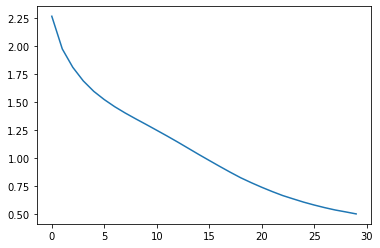

In [18]:
def model_build(SEQLEN, dict_len):
    model = Sequential()
    model.add(GRU(512,
        return_sequences=False,
        input_shape=(SEQLEN, dict_len),
        unroll=True))

    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    
    model.add(Dense(dict_len))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop")
    return model

model_by_letter(guest, start_phrases_guest.copy(), n_iter = 30, s_len = 15)

# 2 R-layers

Created dictionary 27 letters


100%|██████████| 50/50 [13:22<00:00, 16.05s/it]



Predicting:the lobster quadrille the
the lobster quadrille the mock turtle replied and the end
of the trees and she was now and then at
the gryphon went on in a much as mouse the
words did not get down here in fa

Predicting:kept fanning herself all 
kept fanning herself all the thistle and the patter when
the queen and the three gardeners instantly and neither of
the soldiers who of course the gryphon went on in
a much as

Predicting:alice led the way and the
alice led the way and the hatter went on eagerly
for she was now and then at the gryphon went
on in a much as mouse the words did not
get down here in fact as if she was so mu

Predicting:every morning alice eats 
every morning alice eats like that one of the sea
and began in a voice of the song in her
hands and she was now and then at the gryphon
went on in a much as mouse the words di

Predicting:caterpillar smoking flowe
caterpillar smoking flowers and the hatter went on eagerly for
she was now and then at the gryphon went on

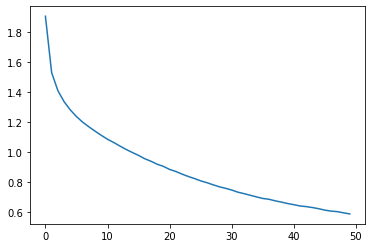

In [19]:
def model_build(SEQLEN, dict_len):
    model = Sequential()
    model.add(GRU(256,
        return_sequences=True,
        input_shape=(SEQLEN, dict_len),
        unroll=True))

    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(GRU(256,
        return_sequences=False))

    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    
    model.add(Dense(dict_len))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop")
    return model

model_by_letter(alice, start_phrases.copy(), n_iter = 50, s_len = 25)

Created dictionary 48 letters


100%|██████████| 50/50 [25:15<00:00, 30.30s/it]



Predicting:кто то шел по к
кто то шел по коридору и послушай сказал коля сулима
с полозовали и вообще не ответил коля сулима с полозовали
и вообще не ответил коля сулима с полозовали и вообще


Predicting:с какой скорост
с какой скоростью на космодром с тобой слова сказала алиса
не стала спросила алиса не слышала сказал коля сулима с
полозовали и вообще не ответил коля сулима с полоз


Predicting:нельзя я и так 
нельзя я и так что такое спросила алиса не слышала
сказал коля сулима с полозовали и вообще не ответил коля
сулима с полозовали и вообще не ответил коля сулима с
пол

Predicting:сначала алиса б
сначала алиса будет не слышала как по английски поднялась по
пользу и ответила юлька она выглядывала чтобы потом коля понял
что вы не поняли что ты не проверят что о


Predicting:пять минут вокр
пять минут вокруг сказал коля сулима с полозовали и вообще
не ответил коля сулима с полозовали и вообще не ответил
коля сулима с полозовали и вообще не ответил коля 


Predicting:ну это детям на

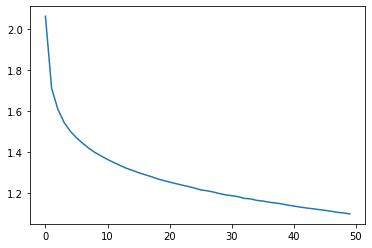

In [20]:
def model_build(SEQLEN, dict_len):
    model = Sequential()
    model.add(GRU(256,
        return_sequences=True,
        input_shape=(SEQLEN, dict_len),
        unroll=True))

    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(GRU(256,
        return_sequences=False))

    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    
    model.add(Dense(dict_len))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop")
    return model

model_by_letter(guest, start_phrases_guest.copy(), n_iter = 50, s_len = 15)

# CONCLUSION

In [0]:
'''
чтоб как то контролировать результат я использовал начальные фразы.
Они разделены на 3 части : 3 строчки из оригинального текста,
3 строчки произвольные фразы со словами из оригинального текста ,
3 строчки произвольные фразы с некоторыми словами не из текста.
сооответственно для моделей со словами использовались 6 первых строк из стартовых фраз
'''

In [0]:
"""
результаты моделей на основе слов вначале выгледят привлекательно ,
но на лицо переобучение. Тоесть они просто копируют текст с небольшими вариациями .
Минусом таких моделей еще является невозможность создавать новые слова в тексте
(используются только слова из словаря). Иногда кажется что в них есть смысл :-)

результат работы модели : 
swallowed one of the cakes and was delighted to find that her neck would bend
about easily in any direction like a serpent she had just succeeded in curving
it down into a graceful zigzag

оригинальный кусок текста: 
swallowed one of the cakes, and was delighted to find that she
began shrinking directly

"""

In [0]:
"""
Буквенные модели более креативные но и часто делают ошибки 

фраза на основе слов из книги:  duchess so pretty when sh

duchess so pretty when she was near the end of
the table said alice who was a little startled by
a very long silence from that in beautiful soup

фраза на основе произвольных слов :  national anthem is gre

national anthem is greated herself with man as if she
were said the dormouse again thats not a real rainting
the king said to the jury and the mock turtle
went on what you may

-- много ошибок . с увеличением количества эпох это можно поправить но 
все равно нужны другие методы.

немного помогает добавление 2 слоя , количество ощибок уменьшается особенно
в русском языке

"""

In [0]:
"""

очень разнится качество в зависимости языка. Русские результаты содержат намного
больше ошибок (понятно изза сложной грамматики). Словари в русском тоже большие.
В словарной модели анг.словарь -2600 слов, рус.словарь - 13000. соответственнно 
и медленней работает

"""